### XGBoost, Multiclass Classification Evaluation and Model Dump

In [48]:
import numpy as np
import pandas as pd
from itertools import cycle

from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import interp

from xgboost import XGBClassifier



rng = 3691

In [49]:
n_classes = 5

In [106]:
x, labels = make_classification(n_samples=10_000, 
                                n_informative=10, 
                                n_classes=n_classes, 
                                weights=[0.1,0.2,0.3,0.2],
                                random_state=rng)
np.unique(labels)

array([0, 1, 2, 3, 4])

In [107]:
xtrain, xtest, ytrain, ytest = train_test_split(x, labels)

In [108]:
clf = XGBClassifier(n_classes=n_classes, random_state=rng, objective="multi:softmax")

In [109]:
clf_p = XGBClassifier(n_classes=n_classes, random_state=rng, objective="multi:softprob")

In [110]:
clf.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_classes=5, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=3691, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [111]:
clf_p.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_classes=5, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=3691, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### objective="multi:softmax"

In [112]:
ypred = clf.predict(xtest)
ypred

array([2, 3, 1, ..., 3, 2, 2])

In [113]:
yprob = clf.predict_proba(xtest)
yprob

array([[3.0677763e-04, 2.1003679e-04, 9.9828064e-01, 3.2699222e-04,
        8.7552489e-04],
       [1.4468195e-02, 4.5642126e-02, 2.9115792e-02, 8.9867288e-01,
        1.2100971e-02],
       [1.9636194e-03, 9.9723721e-01, 2.2308961e-04, 5.1061192e-04,
        6.5427666e-05],
       ...,
       [3.7642159e-03, 1.0284316e-01, 4.3126317e-03, 8.6003143e-01,
        2.9048588e-02],
       [3.0186128e-02, 1.9363698e-03, 9.6459812e-01, 2.8484925e-03,
        4.3095020e-04],
       [3.9277829e-02, 2.0534743e-03, 9.5124996e-01, 1.0209047e-03,
        6.3978685e-03]], dtype=float32)

In [114]:
assert np.argmax(yprob[0,:]) == ypred[0]
ytest[0]

2

In [115]:
error_rate = np.sum(ytest != ypred) / len(ytest)
print(f'{error_rate*100}%')

11.88%


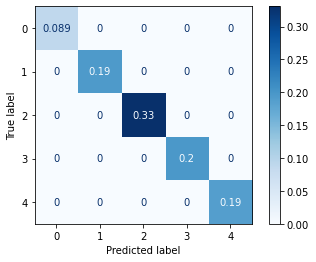

In [116]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(clf, xtest, ypred, normalize='all', cmap=plt.cm.Blues);

In [117]:
# binarize/hot-encode here since we look at each class 
lb = LabelBinarizer()
ytest_b = lb.fit_transform(ytest)

precision = dict()
recall = dict()
avg_prec = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(ytest_b[:, i],
                                                        yprob[:, i])
    avg_prec[i] = metrics.average_precision_score(ytest_b[:, i], yprob[:, i])

In [118]:
# "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(ytest_b.ravel(), 
                                                                        yprob.ravel())

In [119]:
avg_prec["micro"] = metrics.average_precision_score(ytest_b, yprob, average="micro")
ap_micro = avg_prec["micro"]
print(f'Average precision score, micro-averaged over all classes: {ap_micro:0.2f}')

Average precision score, micro-averaged over all classes: 0.94


In [120]:
precision

{0: array([0.10391753, 0.10354785, 0.10359059, ..., 1.        , 1.        ,
        1.        ]),
 1: array([0.20214521, 0.20181593, 0.20189926, ..., 1.        , 1.        ,
        1.        ]),
 2: array([0.30878187, 0.30850202, 0.30862697, ..., 1.        , 1.        ,
        1.        ]),
 3: array([0.29505401, 0.29465301, 0.29482072, ..., 1.        , 1.        ,
        1.        ]),
 4: array([0.23529412, 0.23491592, 0.23503216, ..., 1.        , 1.        ,
        1.        ]),
 'micro': array([0.20049723, 0.20043311, 0.20044919, ..., 1.        , 1.        ,
        1.        ])}

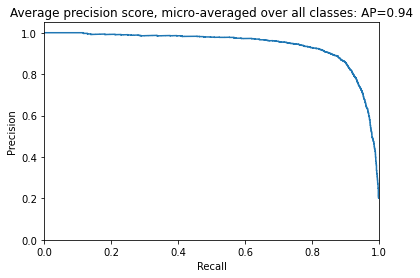

In [121]:
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Average precision score, micro-averaged over all classes: AP={ap_micro:0.2f}');

### by class and average

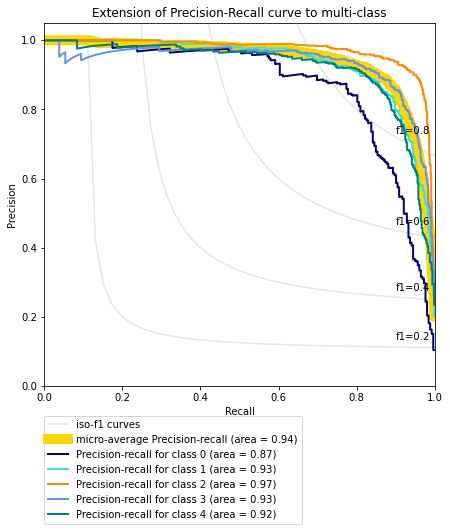

In [122]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=10)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(avg_prec["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, avg_prec[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=10))


plt.show()

### objective="multi:softprob"

all results identical, 

In [123]:
ypred = clf_p.predict(xtest)
ypred

array([2, 3, 1, ..., 3, 2, 2])

In [124]:
yprob = clf_p.predict_proba(xtest)
yprob

array([[3.0677763e-04, 2.1003679e-04, 9.9828064e-01, 3.2699222e-04,
        8.7552489e-04],
       [1.4468195e-02, 4.5642126e-02, 2.9115792e-02, 8.9867288e-01,
        1.2100971e-02],
       [1.9636194e-03, 9.9723721e-01, 2.2308961e-04, 5.1061192e-04,
        6.5427666e-05],
       ...,
       [3.7642159e-03, 1.0284316e-01, 4.3126317e-03, 8.6003143e-01,
        2.9048588e-02],
       [3.0186128e-02, 1.9363698e-03, 9.6459812e-01, 2.8484925e-03,
        4.3095020e-04],
       [3.9277829e-02, 2.0534743e-03, 9.5124996e-01, 1.0209047e-03,
        6.3978685e-03]], dtype=float32)

In [125]:
assert np.argmax(yprob[0,:]) == ypred[0]
ytest[0]

2

In [126]:
error_rate = np.sum(ytest != ypred) / len(ytest)
print(f'{error_rate*100}%')

11.88%


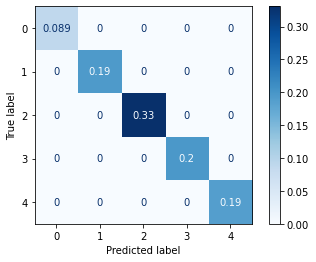

In [127]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
b = plot_confusion_matrix(clf, xtest, ypred, normalize='all', cmap=plt.cm.Blues);

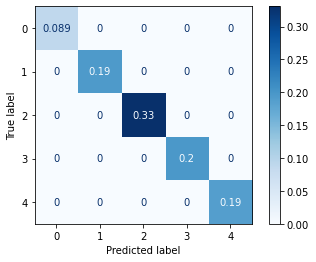

In [128]:
b.figure_

In [129]:
b

In [130]:
# binarize/hot-encode here since we look at each class 
lb = LabelBinarizer()
ytest_b = lb.fit_transform(ytest)

precision = dict()
recall = dict()
avg_prec = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(ytest_b[:, i],
                                                        yprob[:, i])
    avg_prec[i] = metrics.average_precision_score(ytest_b[:, i], yprob[:, i])

In [131]:
# "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(ytest_b.ravel(), 
                                                                        yprob.ravel())

In [132]:
avg_prec["micro"] = metrics.average_precision_score(ytest_b, yprob, average="micro")
ap_micro = avg_prec["micro"]
print(f'Average precision score, micro-averaged over all classes: {ap_micro:0.2f}')

Average precision score, micro-averaged over all classes: 0.94


In [133]:
precision

{0: array([0.10391753, 0.10354785, 0.10359059, ..., 1.        , 1.        ,
        1.        ]),
 1: array([0.20214521, 0.20181593, 0.20189926, ..., 1.        , 1.        ,
        1.        ]),
 2: array([0.30878187, 0.30850202, 0.30862697, ..., 1.        , 1.        ,
        1.        ]),
 3: array([0.29505401, 0.29465301, 0.29482072, ..., 1.        , 1.        ,
        1.        ]),
 4: array([0.23529412, 0.23491592, 0.23503216, ..., 1.        , 1.        ,
        1.        ]),
 'micro': array([0.20049723, 0.20043311, 0.20044919, ..., 1.        , 1.        ,
        1.        ])}

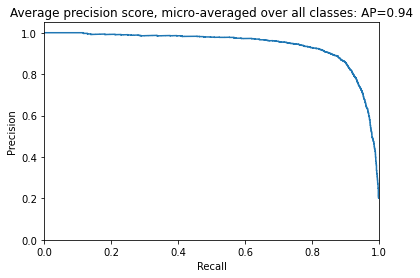

In [134]:
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Average precision score, micro-averaged over all classes: AP={ap_micro:0.2f}');

### by class and average

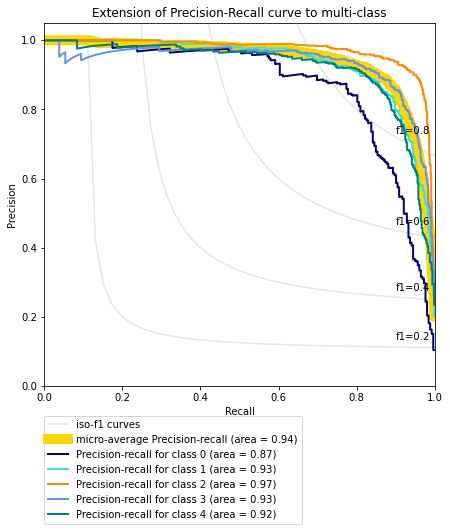

In [135]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=10)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(avg_prec["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, avg_prec[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=10))


plt.show()

### roc curves

In [142]:
key="roc"
plots_dir: str = "plots"
fmt="png"
fpr_label: str = "false positive rate"
tpr_label: str = "true positive rate"
title: str = "roc curve"
legend_loc: str = "best"

In [143]:
# plt.plot([0, 1], [0, 1], "k--")

# # labelling
# plt.xlabel(fpr_label)
# plt.ylabel(tpr_label)
# plt.title(title)
# plt.legend(loc=legend_loc)

# single ROC or mutliple
unique_labels = set(labels)
assert n_classes - len(unique_labels)
is_multiclass = True if len(unique_labels) > 2 else False

if is_multiclass:
    lb = LabelBinarizer()
    ytest_b = lb.fit_transform(ytest)
    # data accummulators by class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(
            ytest_b[:, i], yprob[:, i], pos_label=1
        )
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        #plt.plot(fpr[i], tpr[i], label=f"class {i}")
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(ytest_b.ravel(), yprob.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
else:
    fpr, tpr, _ = metrics.roc_curve(ytest_b, yprob[:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f"positive class")

In [144]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  after removing the cwd from sys.path.


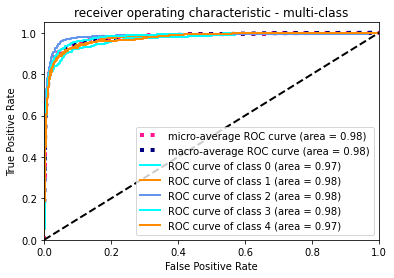

In [145]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('receiver operating characteristic - multi-class')
plt.legend(loc="lower right")
plt.show()

In [146]:
macro_roc_auc_ovo = metrics.roc_auc_score(ytest, yprob, multi_class="ovo",
                                          average="macro")
weighted_roc_auc_ovo = metrics.roc_auc_score(ytest, yprob, multi_class="ovo",
                                             average="weighted")
macro_roc_auc_ovr = metrics.roc_auc_score(ytest, yprob, multi_class="ovr",
                                          average="macro")
weighted_roc_auc_ovr = metrics.roc_auc_score(ytest, yprob, multi_class="ovr",
                                             average="weighted")
print(f"One-vs-One ROC AUC scores:\n{macro_roc_auc_ovo:.6f} (macro),\n{weighted_roc_auc_ovo:.6f} "
      "(weighted by prevalence)")
print(f"One-vs-Rest ROC AUC scores:\n{macro_roc_auc_ovr:.6f} (macro),\n{weighted_roc_auc_ovr:.6f} "
      "(weighted by prevalence)")

One-vs-One ROC AUC scores:
0.974589 (macro),
0.976066 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.976325 (macro),
0.978008 (weighted by prevalence)


## Binary

In [147]:
n_classes = 2

In [182]:
x, labels = make_classification(n_samples=100_000, 
                                n_classes=n_classes, 
                                n_features=40, 
                                weights=[0.4],
                                random_state=rng)

In [183]:
xtrain, xtest, ytrain, ytest = train_test_split(x, labels)

In [184]:
clf = XGBClassifier(n_classes=n_classes, random_state=rng, objective="binary:logistic")

In [185]:
clf.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_classes=2, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=3691, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [187]:
ypred = clf.predict(xtest)
yprob = clf.predict_proba(xtest)

In [190]:
error_rate = np.sum(ytest != ypred) / len(ytest)
print(f'{error_rate*100:.2f}%')

3.85%


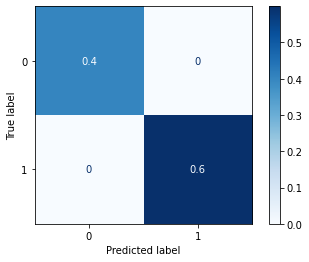

In [191]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(clf, xtest, ypred, normalize='all', cmap=plt.cm.Blues);

In [192]:
metrics.roc_auc_score(ytest, yprob[:,1])

0.9876007825352664

In [193]:
metrics.accuracy_score(ytest, ypred)

0.96148

In [194]:
metrics.f1_score(ytest, ypred)

0.9680077073851368